In the previous [post](https://lucasvw.github.io/posts/15_rnn/) we went in detail through Recurrent Neural Networks (RNN's). We looked at how they are similar to MLPs and how they allow for a large improvement in processing data.

One main problem with RNN's is that it's still relatively difficult for the model to maintain information on something that has happened a long time ago. If in one sentence the subject turns out to be a male, then in the next sentence the model should still remember this, and use "he" as a pronoun when referring to this person. One way to do this, is by extending the sequence length to large values, but this brings its own problems exploding and or vanishing gradients because of the increased depth of the model. 

:::{.callout-note}
Exploding and vanishing gradients is a general problem of neural networks. In an [earlier](https://lucasvw.github.io/posts/11_nntrain_activations/#iterative-matrix-multiplications) blog post we discussed this in the context of deep neural networks for vision applications.
:::

Although there are multiple ways of dealing with this problem such as normalization and initialization, the Long short-term memory (LSTM) layer is another way to deal with this. Instead of increasing the sequence length (and thus increasing the depth of the model), it aims to have a better technique for remembering the past.

## Architecture and Intuition

To discuss the LSTM architecture, let's use the following diagram which displays what happens in a single timestep (the processing of a single token). On the bottom left we see the (embedding activations of the) inputs $x$ and the hidden state $h$, similar to what we have seen in RNN's.

The first thing that's different from an RNN, is that the LSTM architecture uses a second (cell) state $c$ (top left) besides the  hidden state $h$. Whereas in the RNN the hidden state is responsible for both keeping a memory of everything that has happened in the past, as well as having information for predicting the next token. These tasks are split in the LSTM, the cell state is responsible for keeping a memory and the hidden state is concerned with the next token.

Furthermore, the cell state *update* is not going through a neural network layer (the orange boxes), instead the LSTM can update this state by two element-wise operations (bright green circles). This allows it to keep information (remember) for a long time.

The cell state is first multiplied by the output of the forget gate. These outputs first go through a sigmoid non-linearity and are thus between 0 and 1. Multiplications with 1's mean that (parts of the) cell state is kept whereas values of 0 mean that (parts of the) cell state is removed or *forgotton*. The inputs to the forget gate are the concatenation of the previous hidden state and the (embedding activations) of the current input. However, there exist other LSTM's where the previous cell state is concatenated to the inputs as well (for example in the Peephole LSTM, in which all the gates get an input from the cell state).

This mechanism through wich an LSTM can *forget* is important, for example when generating text and the subject of the text changes from male to female.

![](LSTM.png)

In the 2 gates that follow (input gate and cell gate), information is prepared to be added to the cell state. The input gate is outputting activations between 0 and 1 and is responsible for determining which cell state to update, and the cell gate is responsible for creating new candidate values. These two are multiplied together before they are being added to the cell state. 

Finally, the new hidden state gets computed and is basically a filtered version of the (updated) cell state. The cell state is first put through a tanh activation (values between -1 and 1) and then multiplied by sigmoid layer. This sigmoid layer is basically deciding which values of the cell state it wants to use for predicting the next token. The new hidden state is both outputted to the right (for the processing of the next token / timestep) as well as to the top (to be passed to the output layer similarly as in an RNN).

## Data
Everything starts with training data, for a description see an earlier [post](https://lucasvw.github.io/posts/13_ngram/)

Last [post](https://lucasvw.github.io/posts/15_rnn/) the `SequentialDataset` and the `VerticalSampler` were introduced to load data in a way that fits RNN's (and LSTM's):

Let's put this into code, we will create a seperate `LSTMCell` class that holds the logic of a single timestep:

## Manual LSTM

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()        
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)
        
    def forward(self, inp, h, c):
        # inp  [bs, ni]
        # h [bs, nh]
        # c [bs, nh]
        
        h = torch.cat([h, inp], dim=1) # [bs, ni+nh]
        
        forget = torch.sigmoid(self.forget_gate(h)) # [bs, nh]
        c = forget * c                              # [bs, nh]   
        
        inp = torch.sigmoid(self.input_gate(h))     # [bs, nh]
        cell = torch.tanh(self.cell_gate(h))        # [bs, nh]
        
        inp = inp * cell                            # [bs, nh]
        c = c + inp                                 # [bs, nh]
        
        h = torch.sigmoid(self.output_gate(h))      # [bs, nh]
        h = h * torch.tanh(c)                       # [bs, nh]
        
        return h, c

Now let's create an `LSTMNet` that uses this `LSTMCell`. This is a very similar network as the RNN we created in the previous post, we just have to iterate manually through the sequence length and sequentially call the inputs on the cell passing in the hidden and cell state:

In [ ]:
class LSTMNet(nn.Module):
    
    def __init__(self, c2i, embedding_dim, hidden_size, bs):
        super().__init__()
        self.c2i            = c2i
        self.bs             = bs
        self.embedding_dim  = embedding_dim
        self.hidden_size    = hidden_size
        # register as buffer so that its moved to the device by the DeviceS Subscriber
        self.register_buffer('h', torch.zeros((bs, self.hidden_size)))
        self.register_buffer('c', torch.zeros((bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), embedding_dim)
        self.lstm           = LSTMCell(embedding_dim, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        outputs = []
        for i in range(inputs.shape[1]):
            self.h, self.c = self.lstm(inputs[:,i,:], self.h, self.c)
            outputs += [self.h]
        self.h = self.h.detach()
        self.c = self.c.detach()
        return self.hidden2out(torch.stack(outputs, dim=1))
    
    def reset_hidden_state(self):
        device = self.h.get_device()
        self.h = torch.zeros_like(self.h).to(device)
        self.c = torch.zeros_like(self.c).to(device)

And let's see how it performs:

epoch,mode,loss
0,train,2.425
0,eval,2.163
1,train,2.087
1,eval,2.071
2,train,1.976
2,eval,2.001
3,train,1.849
3,eval,1.966
4,train,1.716
4,eval,1.950


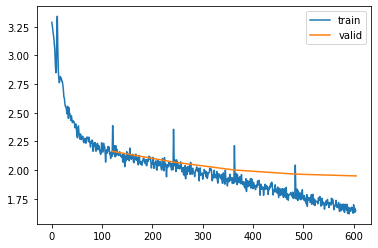

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 1000
embedding_dim  = 100

dls = get_dls(context_length, bs)
lstm = LSTMNet(c2i, embedding_dim, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(lstm, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

With the 2 layer RNN from the previous post, we reached an evaluation loss of 1.976, this is thus a nice improvement!

## PyTorch LSTM

When we use the default PyTorch LSTM, the network is practically identical to the RNN we created in the previous post:

In [ ]:
class PyTorchLSTM(nn.Module):
    def __init__(self, c2i, embedding_dim, hidden_size, bs, layers=1):
        super().__init__()
        self.c2i = c2i
        self.bs = bs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.register_buffer('h', torch.zeros((layers, bs, self.hidden_size)))
        self.register_buffer('c', torch.zeros((layers, bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), embedding_dim)               
        self.lstm = nn.LSTM(embedding_dim, hidden_size, layers, batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        hs, state = self.lstm(inputs, (self.h, self.c))
        # hs : [bs, context_length, hidden_size]
        # h  : [layers, bs, hidden_size]
        self.h = state[0].detach()
        self.c = state[1].detach()
        return self.hidden2out(hs)
    
    def reset_hidden_state(self):
        device = self.h.get_device()
        self.h = torch.zeros_like(self.h).to(device)
        self.c = torch.zeros_like(self.c).to(device)
    

epoch,mode,loss
0,train,2.408
0,eval,2.157
1,train,2.085
1,eval,2.069
2,train,1.971
2,eval,2.003
3,train,1.844
3,eval,1.966
4,train,1.710
4,eval,1.950


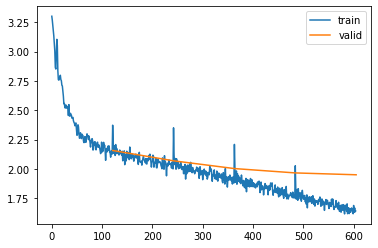

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 1000
embedding_dim  = 100
layers         = 1

dls = get_dls(context_length, bs)
lstm = PyTorchLSTM(c2i, embedding_dim, n_h, bs, layers=layers)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(lstm, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

The result is similar to the manual LSTM.